https://www.kaggle.com/competitions/generated-or-not/overview

# Download libs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import tensorflow as tf
import cv2
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Download data

In [ ]:
train = pd.read_csv('train.csv')
train

,id,target
0,gL5fWrgNPU.jpg,0
1,KKWXJDN8uM.png,1
2,Wb2I0CXlAY.jpg,0
3,G7PLhKpaf7.jpeg,1
4,DEUkeefz6Z.jpg,0
...,...,...
1007,fqoVycdxLV,1
1008,TN2ZOiNI5e.jpg,0
1009,2WMWt6CAWQ.jpg,0
1010,fQCY5n2vcF.jpg,0


In [ ]:
test_df = pd.read_csv('test.csv')
test_df

,id
0,Qt1fGUB0Vz.jpeg
1,j4Rhioq7R3.jpeg
2,rD0hgFHJUZ.jpeg
3,aY5z1EJsJ6.jpeg
4,qZ3IoxD2TE.jpeg
...,...
501,Qrme6EUmL1
502,4369Dl8wfs.jpeg
503,BrNEvRNpPu.jpeg
504,DuwXCNmeMx.webp


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,target
0,Qt1fGUB0Vz.jpeg,0.5
1,j4Rhioq7R3.jpeg,0.5
2,rD0hgFHJUZ.jpeg,0.5
3,aY5z1EJsJ6.jpeg,0.5
4,qZ3IoxD2TE.jpeg,0.5
...,...,...
501,Qrme6EUmL1,0.5
502,4369Dl8wfs.jpeg,0.5
503,BrNEvRNpPu.jpeg,0.5
504,DuwXCNmeMx.webp,0.5


# Images preprocessing

In [5]:
images = tf.keras.utils.image_dataset_from_directory('/images/train_data')

Found 1012 files belonging to 2 classes.


In [6]:
data_iterator = images.as_numpy_iterator() # to make data pipeline

In [7]:
batch = data_iterator.next() # to iterate data pipeline
len(batch)

2

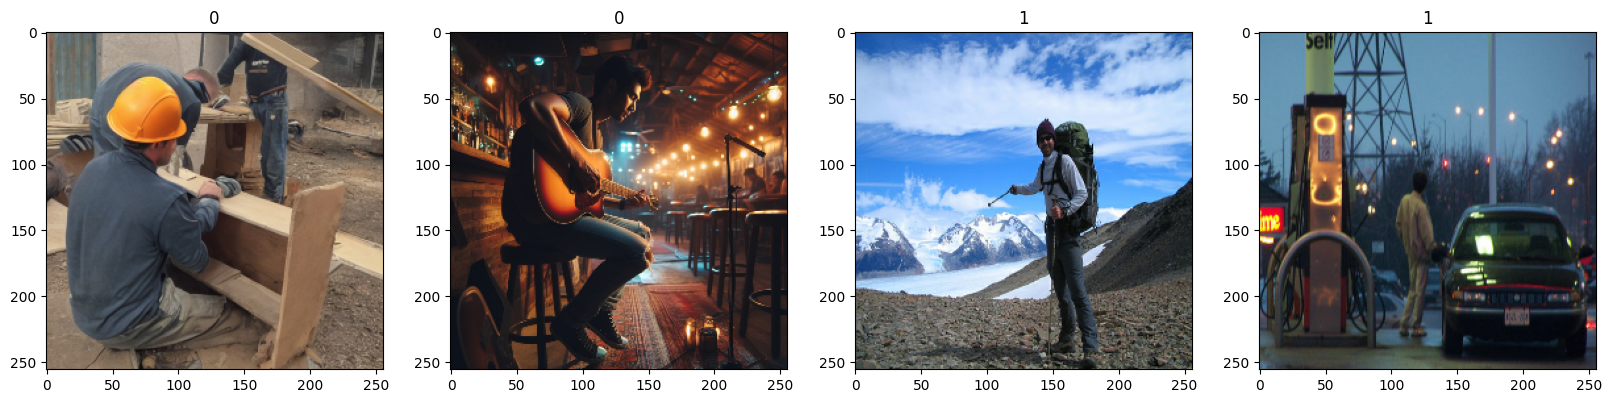

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale data

In [8]:
data = images.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()

1.0

# Split data

In [9]:
len(data)

32

We have 32 batches of images, now we need to split it.


In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) +1
test_size = int(len(data)*.1)
train_size, val_size, test_size

(22, 7, 3)

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# CNN model

In [126]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(8, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [127]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [128]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 30, 30, 16)       

In [130]:
logdir='logs'

In [131]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [132]:
hist = model.fit(train, validation_data=test,epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
22/22 [==============================] - 65s 2s/step - loss: 0.6815 - accuracy: 0.6548 - val_loss: 0.6559 - val_accuracy: 0.6548
Epoch 2/20
22/22 [==============================] - 67s 3s/step - loss: 0.6480 - accuracy: 0.6634 - val_loss: 0.6295 - val_accuracy: 0.6667
Epoch 3/20
22/22 [==============================] - 66s 3s/step - loss: 0.6006 - accuracy: 0.6634 - val_loss: 0.5567 - val_accuracy: 0.6548
Epoch 4/20
22/22 [==============================] - 66s 3s/step - loss: 0.5731 - accuracy: 0.6676 - val_loss: 0.5405 - val_accuracy: 0.7381
Epoch 5/20
22/22 [==============================] - 55s 2s/step - loss: 0.5379 - accuracy: 0.7088 - val_loss: 0.4780 - val_accuracy: 0.7143
Epoch 6/20
22/22 [==============================] - 57s 2s/step - loss: 0.4685 - accuracy: 0.7770 - val_loss: 0.4499 - val_accuracy: 0.8095
Epoch 7/20
22/22 [==============================] - 58s 2s/step - loss: 0.4456 - accuracy: 0.7926 - val_loss: 0.3970 - val_accuracy: 0.8214
Epoch 8/20
22/22 [==

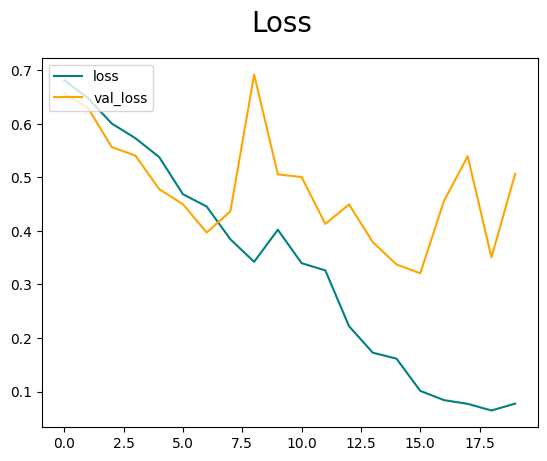

In [133]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

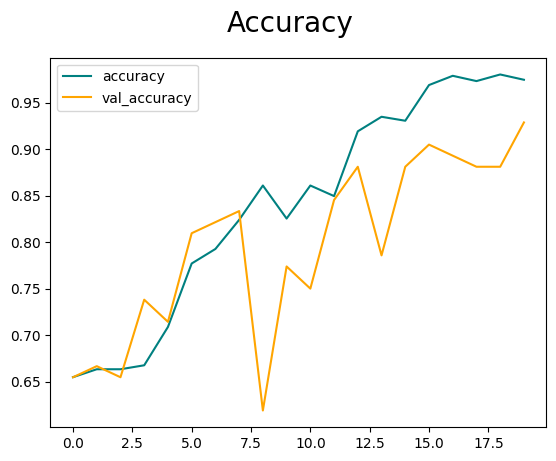

In [134]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Model evaluation

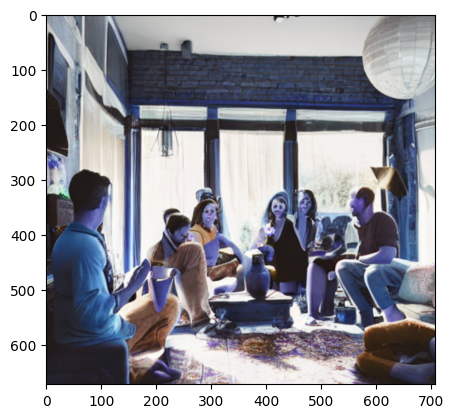

In [114]:
img = cv2.imread('/images/test_data/5ub2eoY4gg.png')
plt.imshow(img)
plt.show()

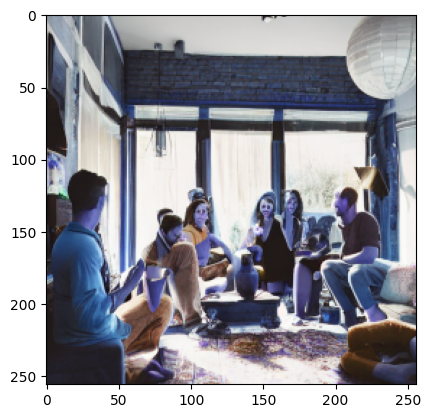

In [115]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [116]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 129ms/step


array([[0.35701635]], dtype=float32)

In [117]:
yhat

array([[0.35701635]], dtype=float32)

In [118]:
if yhat > 0.5:
    print(f'Predicted class is REAL')
else:
    print(f'Predicted class is AI')

Predicted class is AI
